 

<center><h1>Real-Time Location System Case Study 1</h1> </center>

<center><h2>Cho Kim, Jason Lin, Jonathan Marin</h2> </center>

<br/>

<center><h2>January, 18 2019</h2></center>

In [75]:

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

## Checklist
* thorough data analysis into these two MAC addresses
    * determining locations by using data corresponding to both MAC addresses
* which of the two MAC addresses should and shouldn’t be used for RTLS
* which MAC has best location prediction
* if using both MAC address data, how does that effect location prediction
    * this portion is derived from Exercise Q.9 in Nolan and Lang
* use this different KNN prediction method
    * use weights on the received signal strength, where the weight is inversely proportional to the “distance” from the test observation
        * This allows for the “nearest” points to have a greater contribution to the k-nearest neighbor location calculation than the points that are “further” away
    * what range of values of weights are you able to obtain better prediction values than for the unweighted k-nearest neighbor approach?
    * Use calcError() to compare this approach to the simple average.
* Include an introduction to explain the case study, explain the approach used to complete the case study and explain the output achieved.  Explanations of output should be included as close to the output or figures as possible.
* List all references used, including the book by Nolan and Lang

<br/>
<br/>

<center>  **Abstract** </center>

Write up Abstract here

## 1 Introduction

There is a growing need to track the location of people inside buildings. Since global positioning systems (GPS) use signals obtained from satellites to determine the user's location at a point in time, GPS signals become scattered inside buildings due to roofs, walls, etc. that they are unable to accurately track a user's location inside a building. Indoor positioning systems (IPS) must be used in lieu of GPS to track people reliably within buildings. IPS uses "WiFi signals detected from network access points" [1] to locate devices on the network in real time. 

The datasets used for this case study were available on the Community Resource for Archiving Wireless Data at Dartmouth (CRAWDAD) website. For this case study, the dataset was downloaded from the course textbook's website: http://rdatasciencecases.org/Data.html. The dataset is described as "traces of signal strength of 802.11 APs for the COMPASS positioning system." [2] By measuring the signal strength at known points throughout the building, an IPS can be built by training the model. The model to predict the location of a device will be based on the signal strength between the device and the different access points. This case study will focus on using k nearest neighbors (KNN) to predict the location of the device.


The KNN algorithm searches through the entire training set for classification using the signal strength, location, orientation, and access points variables.  Firstly, a number `k` must be selected manually. The `k` determines how many neighbors will be included when trying to predict the location on the test set. The training dataset will be used to calculate the distance between the known neighbors and the unknown location `(x,y)` on the test dataset using the Euclidean distance formula: $\sqrt{(S_{1}^{*}-S_{1})^{2}+\cdots+(S_{6}^{*}-S_{6})^{2}}$. Once the distance between the test data and train data is calculated, the location can be predicted based on the majority vote of the nearest neighbors. 

<br/>

## 2 Methods

For the case study, the offline dataset was imported to train and build a model. After reviewing the import of the raw data file, values for each variable were extracted; then, data cleaning and exploratory data analysis were done. The signal strength was analyzed. The locations were predicted using KNN and weighted KNN for the separate media access control (MAC) addresses and together. 

The effectiveness of the location prediction was tested by using the online dataset. <span style="color: red">REVIEW THIS SECTION FOR CORRECTNESS</span>

#### Data Description

**Offline Dataset**

The offline dataset "contains signal strengths measured using a hand-held device on a grid of 166 points spaced 1 meter apart in the hallways of one floor of a building at the University of Mannheim." [1] The locations where the offline data was collected is denoted by grey dots in Figure 1 below. The black squares in the floor plan below denote the 6 fixed access points. For each access point, there were 110 signal strength measurements at 8 orientations (45 degree increments: 0&deg;, 45&deg;, 90&deg;, 135&deg;, 180&deg;, 225&deg; 270&deg;, 315&deg;) recorded by the hand-held device. The textbook mentions that, "measurements from other hand-held devices, e.g., phone or laptop, in the vicinity of the experimental unit appear in some offline records." [1] These measurements should be discarded in our dataset. <span style="color: red">Were these observations actually discarded or am I lying?</span>

**Online Dataset**

For the online dataset, "60 locations and orientations [were] chosen at random." [1] There were 110 signal strength measurements for each location relative to the access point. The locations chosen at random are denoted by the black dots on Figure 1 below.

<center>**Figure 1: Floor Plan where Data Was Collected**</center>
![title](floorplan.jpg)
<br><br>

<center>**Table 1: Dataset Description**<br>
Source: p.6 and Table 1.1: Units of Measurement from textbook [1]</center>

| Variable Name  | Description                          | Units                                                                                                                                                                                                                                             |
|----------------|--------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| t              | Timestamp                            | timestamp in milliseconds since midnight, January 1, 1970 UTC                                                                                                                                                                                     |
| id             | MACofScanDevice                      | MAC address of the scanning device                                                                                                                                                                                                                |
| pos            | RealPosition                         | the physical coordinate of the scanning device                                                                                                                                                                                                    |
| degree         | orientation                          | orientation of the user carrying the scanning device in degrees                                                                                                                                                                                   |
| MACofResponse1 | SignalStrengthValue, Frequency, Mode | MAC address of a responding peer (e.g., an access point or a device in adhoc mode) with the corresponding values for signal strength in dBm (Decibel-milliwatts), the channel frequency and its mode (access point = 3, device in adhoc mode = 1) |
| MACofResponseN | SignalStrengthValue, Frequency, Mode | MAC address of a responding peer (e.g., an access point or a device in adhoc mode) with the corresponding values for signal strength in dBm (Decibel-milliwatts), the channel frequency and its mode (access point = 3, device in adhoc mode = 1) |

The table above describes both offline and online datasets.

<center>**Figure 2: Screenshot of Raw Data File from Textbook**</center>
![title](rawdatascreenshot.png)

Figure 2 above shows that the first three rows in the raw data file does not contain data points and only comments related to the data file. The comments began with a `#` symbol. Any line beginning with a `#` was discarded in the analysis since it is not an observation.

#### Data Import

To train our model, the offline file was imported and read by R for each line as text. The number of lines that began with a `#` symbol were counted using the `substr()` function. `5,312` lines began with a `#` in the offline file. There was a total of `151,392` lines in the file. The textbook states that there should be "`146,080` lines in the file." This was verified by calculating the number of expected lines in the file ($166\ locations * 8\ angles * 110\ recordings = 146,080$). When the number of lines that begin with `#` is subtracted from the total number of lines, this matches the expected number of observations in the file. 

#### Data Processing

The offline data file was processed by identifying that the data elements were separated by a semicolon. Each data element contained the variable name and the value separated by an equal sign. For each MAC address, the signal strength, channel, and device type were separated by a comma.  Using the `strsplit()` function, the data elements were separated by `;`, `=`, and `,`. The custom `processLine` function from the textbook, returns a null value if the token vector has 10 elements and separates the data by the special characters mentioned. The dimensions of the offline dataframe was checked and verified that it matched the textbook. There were `1181628` rows of data in the offline dataframe at this time.

#### Data Cleaning

As part of the data cleaning step, variable names were assigned to the dataset and converted to the correct type. Table 2 shows the value and the related device type. For the analysis, `adhoc` measurements were removed from the offline data frame since only `access point` is relevant for the case study and the `type` variable was removed leaving `978,443` records in the data frame.

<center>**Table 2: Device Type Factors**</center>

| Device Type  | Numerical Value |
|--------------|-----------------------------|
| adhoc        | 1                           |
| access point | 3             |

The `time` variable was converted from milliseconds to seconds to match the `POSIXt` format. Below is a summary of the numeric variables to verify that the data looks correct. From the summary output below, the `posZ` values are all `0`. Because all measurements were taken on one floor, there are no `posZ` values. After analysis, the `posZ` variable was removed from the data frame.

In [12]:
summary(offline[, numVars])

      time                          posX         posY           posZ  
 Min.   :2006-02-11 01:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 07:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 13:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 08:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 08:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 14:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

The character variables were converted to factors in the data frame. The summary table of the character variables is below:

In [13]:
summary(sapply(offline[ , c("mac", "channel", "scanMac")],
               as.factor))

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

There is only one MAC address for the `scanMac` variable since there was only one hand-held device used to take measurements. The `scanMac` variable was removed from the data frame. 

** Orientation **

The observations for this dataset were measured at 8 equally spaced orientations for each location. To check if this is correct, unique values of the `orientation` variable were examined below. If the data frame, were clean there would be no values returned. For further examination, the `orientation` variable distribution was plotted (see Figure 3). The plot of the empirical distribution function shows that the orientation data points are distributed among the 8 orientations.

In [19]:
length(unique(offline$orientation))

[1] 203

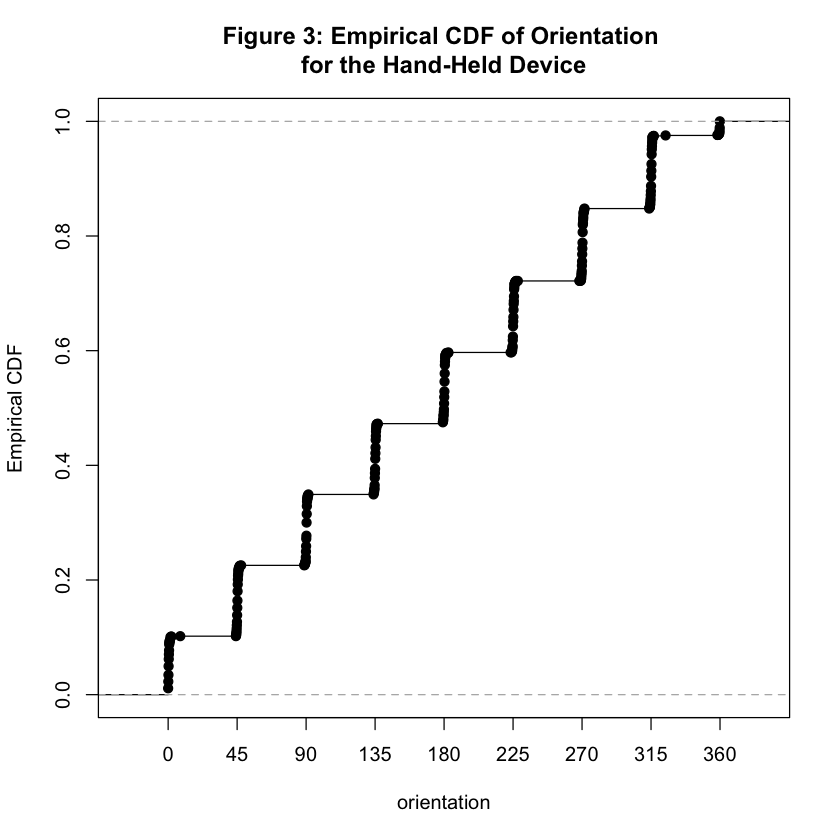

In [20]:
plot(ecdf(offline$orientation), main = "Figure 3: Empirical CDF of Orientation \nfor the Hand-Held Device", ylab = "Empirical CDF", xlab = "orientation", axes=FALSE)
axis(side = 1, at = seq(0, 360, by = 45))
axis(2)
box()

<span style="color:red">DISCUSS THE DENSITY PLOT</span>

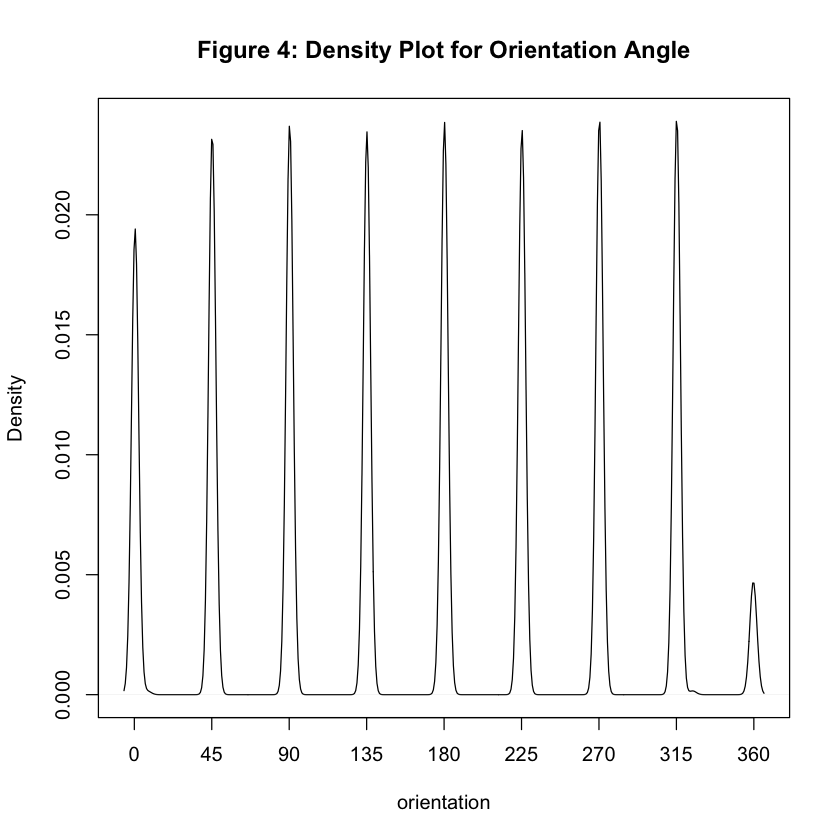

In [23]:
plot(density(offline$orientation, bw = 2), 
     xlab = "orientation", main = "Figure 4: Density Plot for Orientation Angle", axes=FALSE)
axis(side = 1, at = seq(0, 360, by = 45))
axis(2)
box()

## 3 Results

### MAC Address 00:0f:a3:39:e1:c0  Distribution Analysis

Based on the given location, the distribution can be compared to one another to see if there is any predictive power in location. When looking at the MAC Address 00:0f:a3:39:e1:c0, we see from the box plots that there is strong signal strength in that given location. Indicating that it may predictive power for that given area. When looking at the densities for the given MAC address, there is some normal distributions but there is also good majority that is left skew. Also when looking at the Mean Signal vs. Standard Deviaton of Signal for the given MAC address, there is some high variability in the stronger signals.

null device 
          1

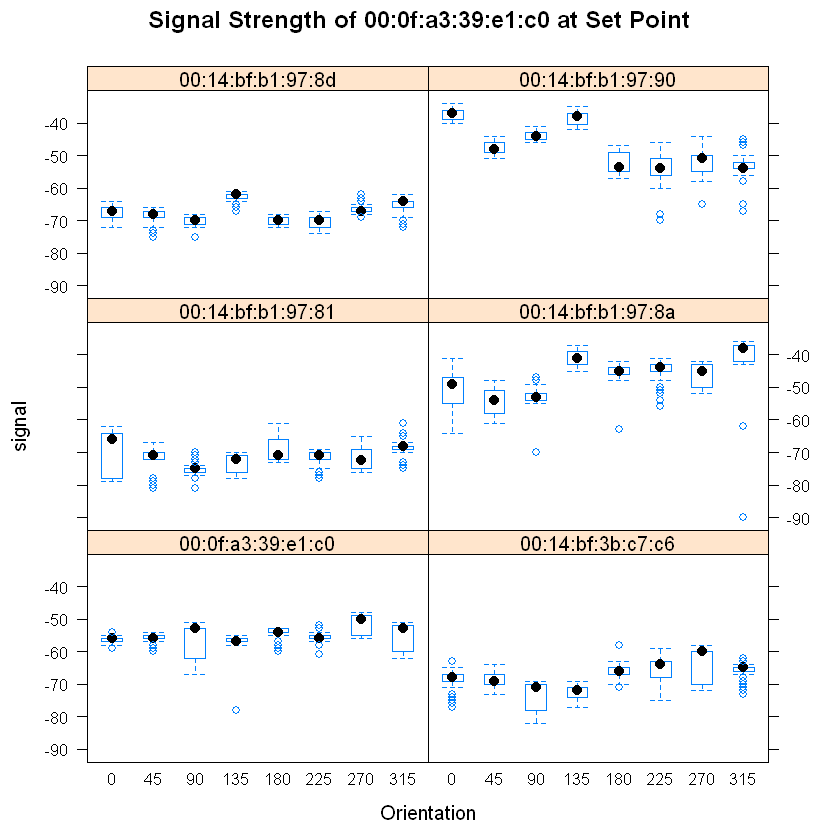

In [141]:
library(IRdisplay)




#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offlineRedo, xlab= "Orientation", main="Signal Strength of 00:0f:a3:39:e1:c0 at Set Point",
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

par(oldPar)
dev.off()




   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -93     -64     -58     -58     -51     -25 

null device 
          1

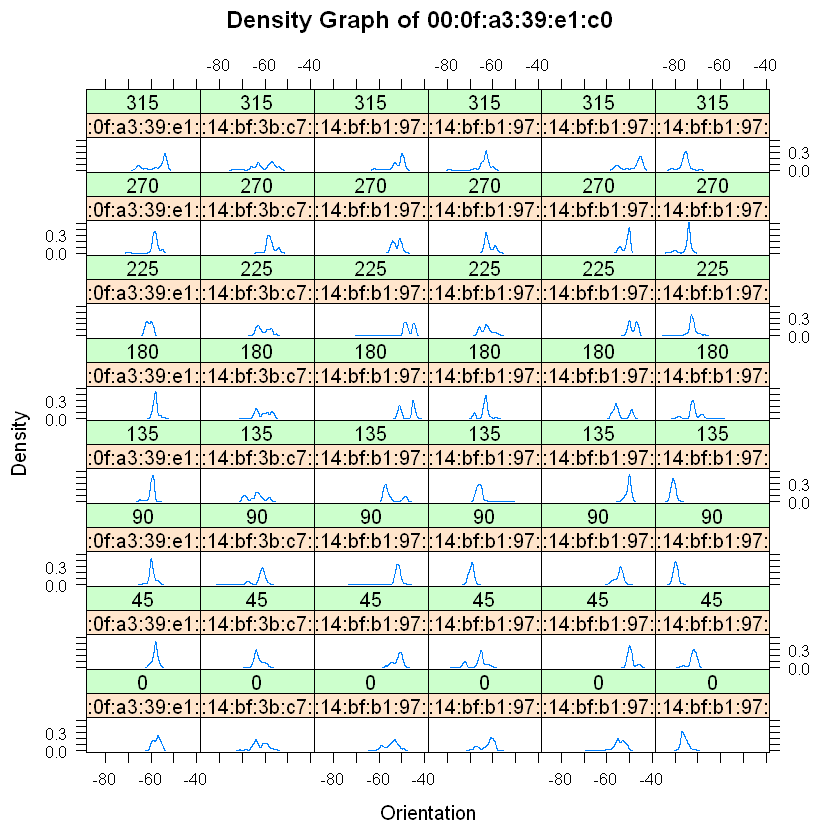

In [142]:
summary(offlineRedo$signal)

#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offlineRedo, xlab= "Orientation", main="Density Graph of 00:0f:a3:39:e1:c0",
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

In [143]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offlineRedo$posXY = paste(offlineRedo$posX, offlineRedo$posY, sep = "-")

byLocAngleAPRedo = with(offlineRedo, 
                    by(offlineRedo, list(posXY, angle, mac), 
                       function(x) x))

In [144]:
signalSummaryRedo = 
  lapply(byLocAngleAPRedo,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

null device 
          1

null device 
          1

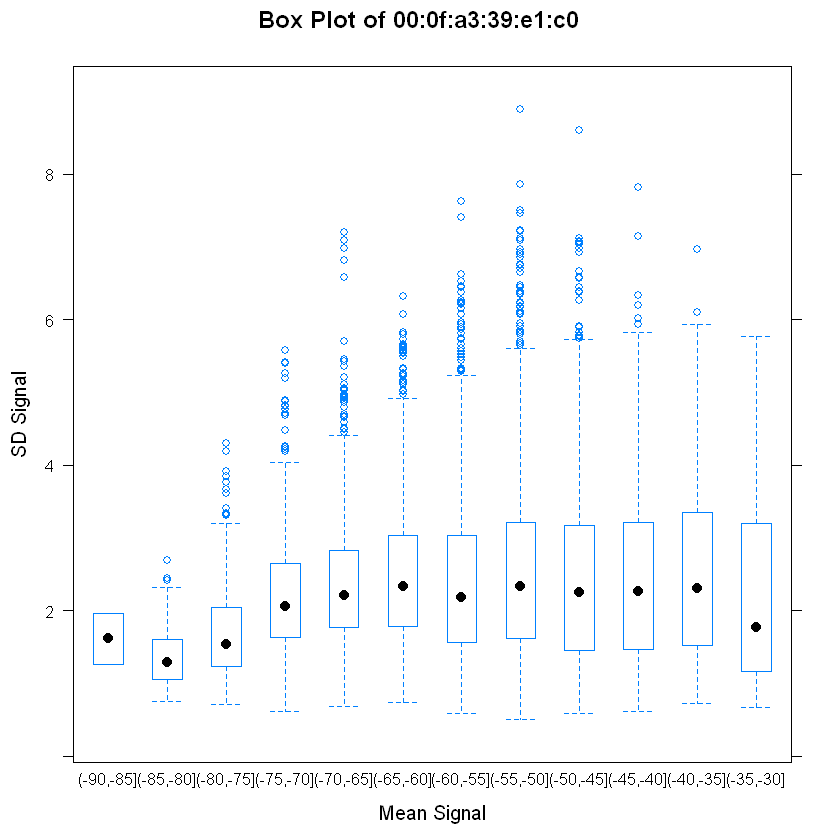

In [145]:

offlineSummaryRedo = do.call("rbind", signalSummaryRedo)     

#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummaryRedo, 
       subset = mac != "00:0f:a3:39:dd:cd",main="Box Plot of 00:0f:a3:39:e1:c0",
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummaryRedo,
     smoothScatter((avgSignal - medSignal) ~ num, 
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)
lo.obj = 
  with(offlineSummaryRedo,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()


### MAC Address 00:0f:a3:39:dd:cd Distribution Analysis

Based on the graphs show below, with the given MAC Address 00:0f:a3:39:dd:cd, there is low signal strength at the given location. Also when looking at the density graphs, the given MAC Address seems to have more left skewness in many of its distribution. Also when looking at the box of the average signal and standard deviaton, there seems to be high variability in the low signal strength with also high variability in the high signal strength. This could indicate better predictability of location since there is more variability in the low signal strength area. 

null device 
          1

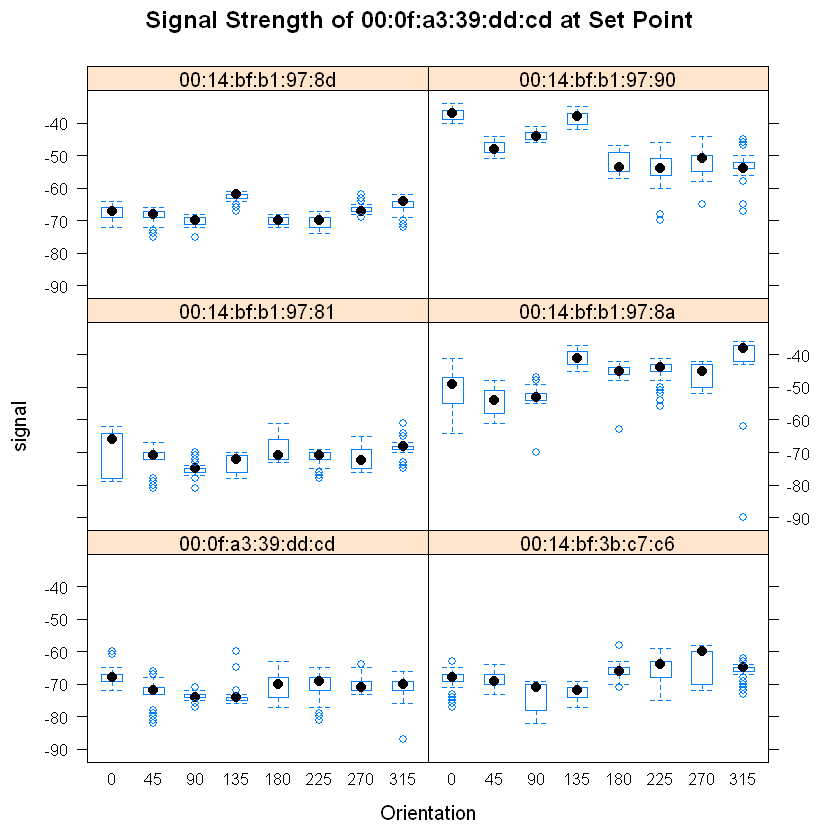

In [146]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offlinenew, xlab= "Orientation", main="Signal Strength of 00:0f:a3:39:dd:cd at Set Point",
       subset = posX == 2 & posY == 12 
                , 
       layout = c(2,3))

par(oldPar)
dev.off()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -69     -61     -61     -54     -25 

null device 
          1

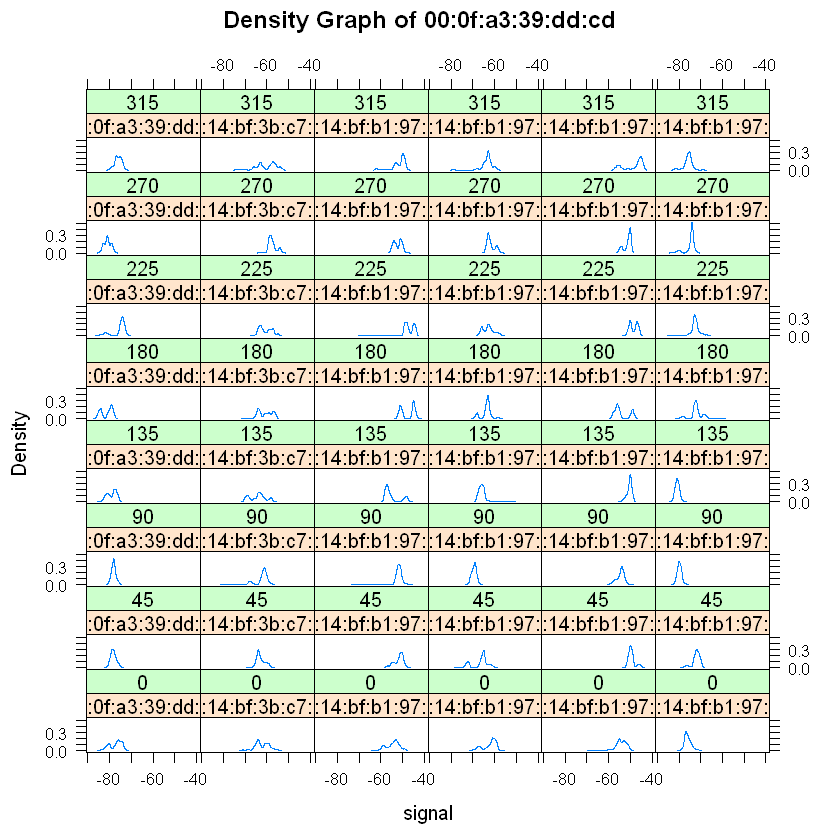

In [147]:
summary(offlinenew$signal)

#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offlinenew,main="Density Graph of 00:0f:a3:39:dd:cd",
             subset = posX == 24 & posY == 4,
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

In [148]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offlinenew$posXY = paste(offlinenew$posX, offlinenew$posY, sep = "-")

byLocAngleAPnew = with(offlinenew, 
                    by(offlinenew, list(posXY, angle, mac), 
                       function(x) x))

In [149]:
signalSummarynew = 
  lapply(byLocAngleAPnew,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

null device 
          1

null device 
          1

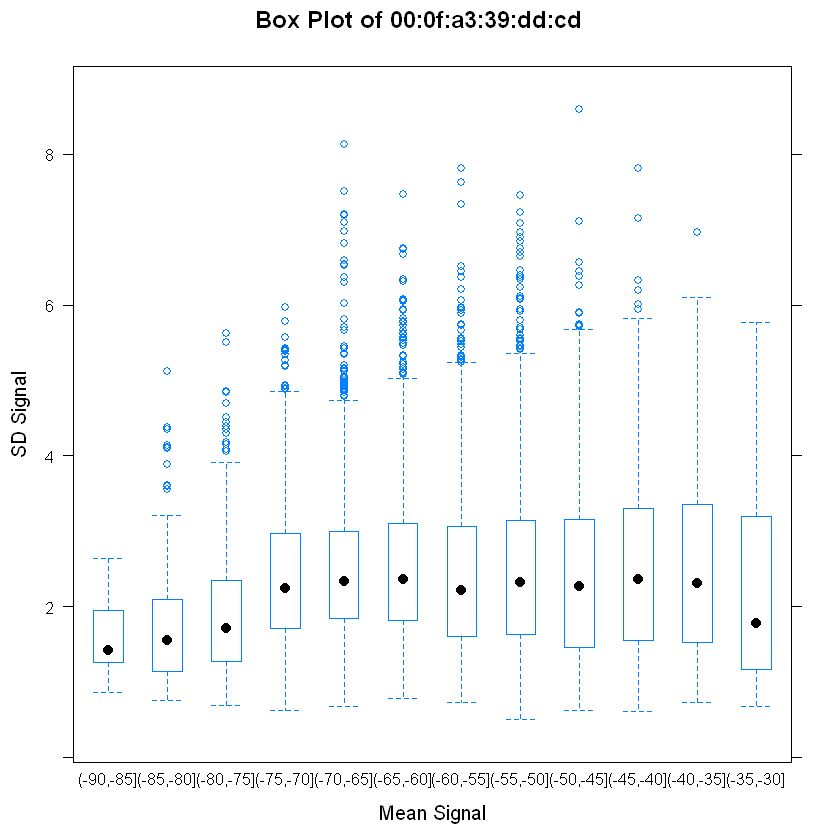

In [150]:
offlineSummarynew = do.call("rbind", signalSummarynew)     

#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),main="Box Plot of 00:0f:a3:39:dd:cd",
       data = offlineSummarynew, 
       
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummarynew,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)
lo.obj = 
  with(offlineSummarynew,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()

### Both MAC Address Distribution Analysis

When looking at the boxplots for the set location, we can see that there is some difference in signal strength between the two MAC Address. This could indicate more predicatbility in the model since there is more variability in the data and can pick up signals that the other could not pick up. However, there is possibility the two signals could be similar in a statistical sense, so more analysis would need to be done on this. When looking at the box plot of Average Signal and Standard deviaton of signals, there seems to higher variability in the lower signal area compared to the other MAC Addresses plots. This could indicate better predicatability since there is more ability to pick up signals in this sepectrum allowing for more accuracy in predictions of locations. 

null device 
          1

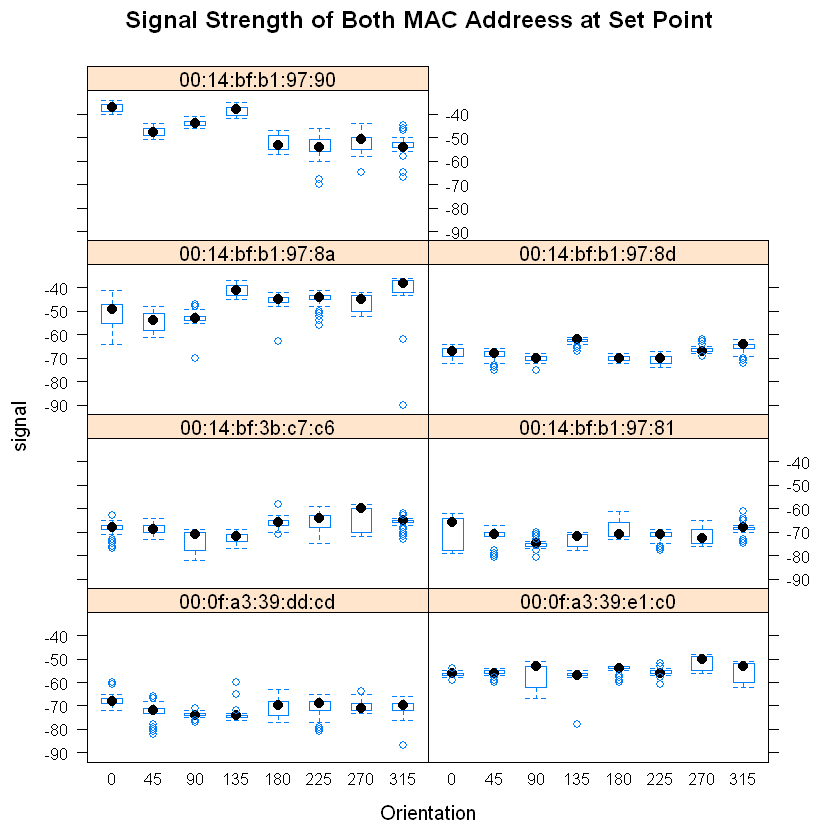

In [151]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offlineBoth, xlab= "Orientation",main="Signal Strength of Both MAC Addreess at Set Point",
       subset = posX == 2 & posY == 12 
                , 
       layout = c(2,4))

par(oldPar)
dev.off()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

null device 
          1

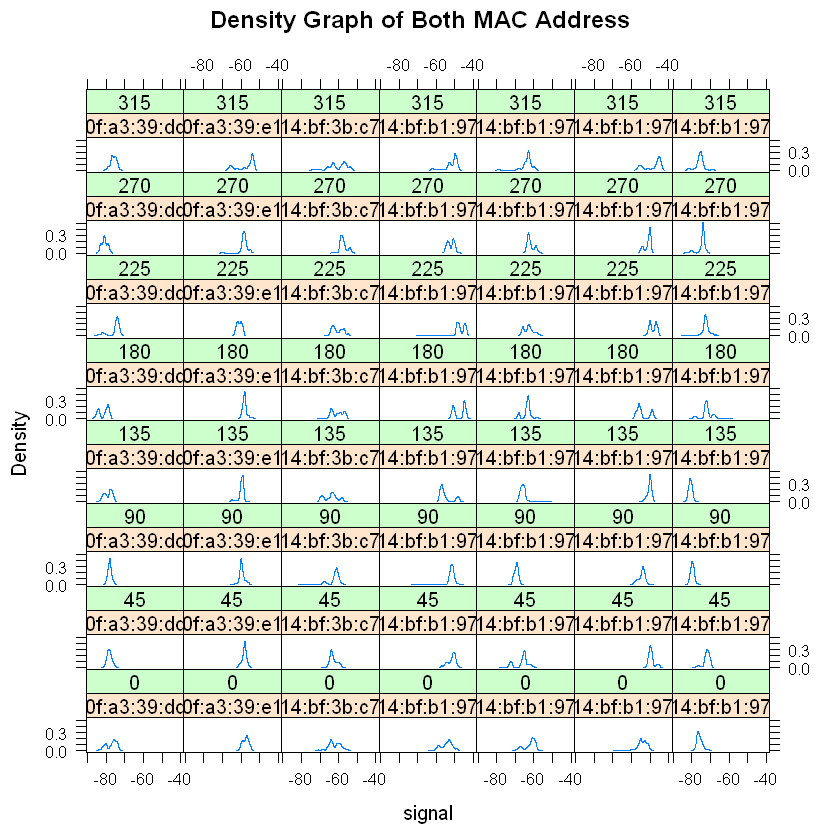

In [152]:
summary(offlineBoth$signal)

#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offlineBoth, main="Density Graph of Both MAC Address",
             subset = posX == 24 & posY == 4,
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

In [153]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offlineBoth$posXY = paste(offlineBoth$posX, offlineBoth$posY, sep = "-")

byLocAngleAPBoth = with(offlineBoth, 
                    by(offlineBoth, list(posXY, angle, mac), 
                       function(x) x))

In [154]:
signalSummaryBoth = 
  lapply(byLocAngleAPBoth,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

null device 
          1

null device 
          1

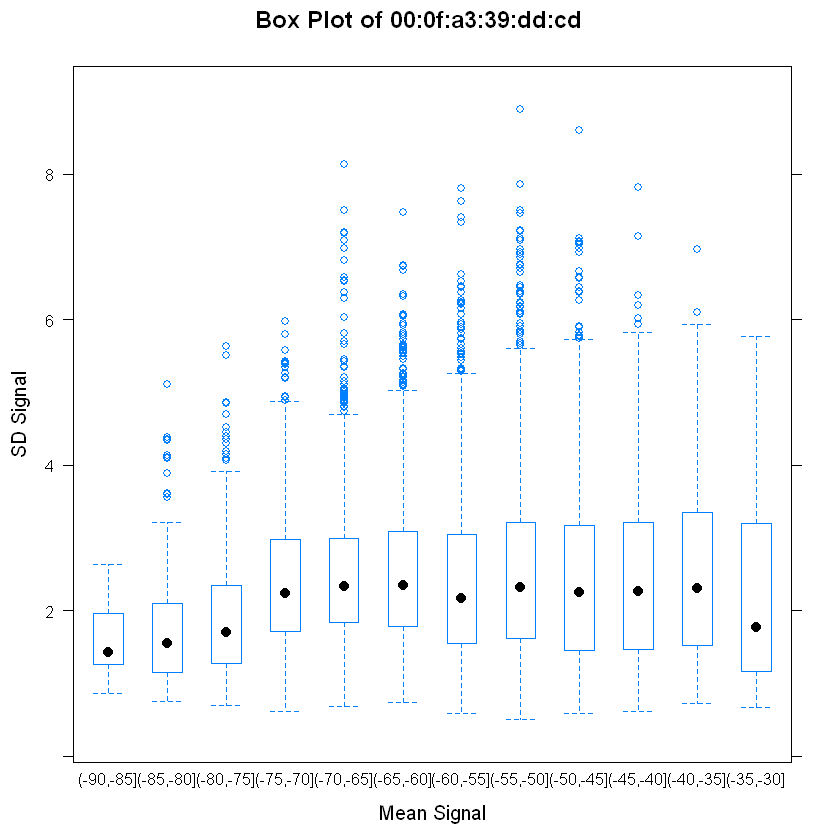

In [155]:
offlineSummaryBoth = do.call("rbind", signalSummaryBoth)     

#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),main="Box Plot of 00:0f:a3:39:dd:cd",
       data = offlineSummaryBoth, 
       
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummaryBoth,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)
lo.obj = 
  with(offlineSummaryBoth,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()

# Accuracy of Location Prediction

When using the three different set of data, we use the function calcError() to estimate the mean square error between the prediction and the actuals. The following MSE for including only MAC Addresss 00:0f:a3:39:e1:c0 is 272.40. the following MSE for including only MAC Address 00:0f:a3:39:dd:cd is 252.33. The following MSE for including both MAC Address is 211.17.

When using the weighted average using the inverse of the distance obtained from the KNN model.The following MSE for including only MAC Addresss 00:0f:a3:39:e1:c0 is the value 271.27. the following MSE for including only MAC Address 00:0f:a3:39:dd:cd is the value 242.40. The following MSE for including both MAC Address is the value 207.25.  

## 4 Conclusion

When looking at the different plots it seems to show that the more variability in all ranges of the signal strength the better predictability of the location. However, therefore from the plots alone having Both MAC Addresses seems to have better predicabiity since the box plots show this in the case of average signal strength vs. standard deviaton of signal strength. When looking at the box plots for signal strength based on one location, the both MaC Address data set seems to show better predictability. This is further supported when looking at the MSE using the simple average for the location for the nearest neighbors where the both MAC Address data set has the lowest MSE. 

In concern with the new weighted average methodolgy, the code was found in a github repository please see the reference. The methodology that it uses is similar to what is referenced in the Nolan Text. The code utilizes the Euclidean distances that is calculated from the KNN function. From there the weights are calculated accordingly and times with the corresponding X and Y coordinates and summed with the number of neigbors to obtain the average. The MSE shows that is has decreased it by a few points. Indicating that the weighting of closer points leads to a more accurate prediction of location. The new weighted average methodology still shows that having both MAC Address in the data set has the lowest MSE. 

<br/>

## Appendix

### References
1. Nolan, Deborah, and Duncan Temple Lang. Data Science in R: a Case Studies Approach to Computational Reasoning and Problem Solving. Crc Press Inc., 2015.
2. Thomas King, Stephan Kopf, Thomas Haenselmann, Christian Lubberger, Wolfgang Effelsberg, CRAWDAD dataset mannheim/compass (v. 2008‑04‑11), downloaded from https://crawdad.org/mannheim/compass/20080411, Apr 2008.

*Need to cite Slater's code Unit2-Cluster*
*Need to cite Yao's notebook*

## A Code

### Generic Code to Pull Raw

In [8]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

options(digits = 2)

txt = readLines("offline.final.trace.txt")

#use substr function to locate lines that begin with # and tally them
sum(substr(txt, 1, 1) == "#")
paste("Number of lines that begin with #: ",sum(substr(txt, 1, 1) == "#"))
paste("Number of lines in offline file: ",length(txt))

#####################################
##    Begin data cleaning step     ##
#####################################

# evaluate how semi-colon splits 4th line of data file (first line that's not a comment)
print("Output of strsplit on 4th line below")
strsplit(txt[4], ";")[[1]]

# split data at a ; or = or , character
tokens = strsplit(txt[4], "[;=,]")[[1]]

# print first 10 elements of variable, tokens that give info about handheld device
tokens[1:10]

# extract values of the variables
tokens[c(2, 4, 6:8, 10)]

# review remaining values in split vector
tokens[ - ( 1:10 ) ]

# create matrix
tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
                   ncol = 6, byrow = TRUE), 
            tmp)

# confirm dimensions of matrix
dim(mat)

# create function processLine to repeat for all rows in txt
processLine =
  function(x)
  {
    tokens = strsplit(x, "[;=,]")[[1]]
    tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
    cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
                 ncol = 6, byrow = TRUE), tmp)
  }

# apply function to txt
tmp = lapply(txt[4:20], processLine)

# determine # of signals detected at each point
sapply(tmp, nrow)

# create offline dataframe
offline = as.data.frame(do.call("rbind", tmp))
dim(offline)

# discard lines beginning with # because they are comments
lines = txt[ substr(txt, 1, 1) != "#" ]

tmp = lapply(lines, processLine)

# revised function to discard observations with no signal detected
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
  
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

options(error = recover, warn = 1)
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), 
                        stringsAsFactors = FALSE)

[1] 5312

[1] "Number of lines that begin with #:  5312"

[1] "Number of lines in offline file:  151392"

[1] "Output of strsplit on 4th line below"


[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"

[1] "1139643118358"     "00:02:2D:21:0F:33" "0.0"              
[4] "0.0"               "0.0"               "0.0"

[1] "00:14:bf:b1:97:8a" "-38"               "2437000000"       
 [4] "3"                 "00:14:bf:b1:97:90" "-56"              
 [7] "2427000000"        "3"                 "00:0f:a3:39:e1:c0"
[10] "-53"               "2462000000"        "3"                
[13] "00:14:bf:b1:97:8d" "-65"               "2442000000"       
[16] "3"                 "00:14:bf:b1:97:81" "-65"              
[19] "2422000000"        "3"                 "00:14:bf:3b:c7:c6"
[22] "-66"               "2432000000"        "3"                
[25] "00:0f:a3:39:dd:cd" "-75"               "2412000000"       
[28] "3"                 "00:0f:a3:39:e0:4b" "-78"              
[31] "2462000000"        "3"                 "00:0f:a3:39:e2:10"
[34] "-87"               "2437000000"        "3"                
[37] "02:64:fb:68:52:e6" "-88"               "2447000000"       
[40] "1"                 "02:00:42:55:31:00" "-84"              
[43] "2457000000"        "1"

[1] 11 10

[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

[1] 170  10

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”

### Creates the field names and also changes the formatting of the variables to numeric since all were character before. Drops the adhoc data and coverts the time to milliseconds

In [9]:
dim(offline)

names(offline) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)

offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

[1] 1181628      10

[1] 978443      9

In [10]:
# check variable types
unlist(lapply(offline, class))

summary(offline[, numVars])

# convert character variables to factors
summary(sapply(offline[ , c("mac", "channel", "scanMac")],
               as.factor))

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

      time                          posX         posY           posZ  
 Min.   :2006-02-11 01:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 07:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 13:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 08:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 08:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 14:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

[1] 203

null device 
          1

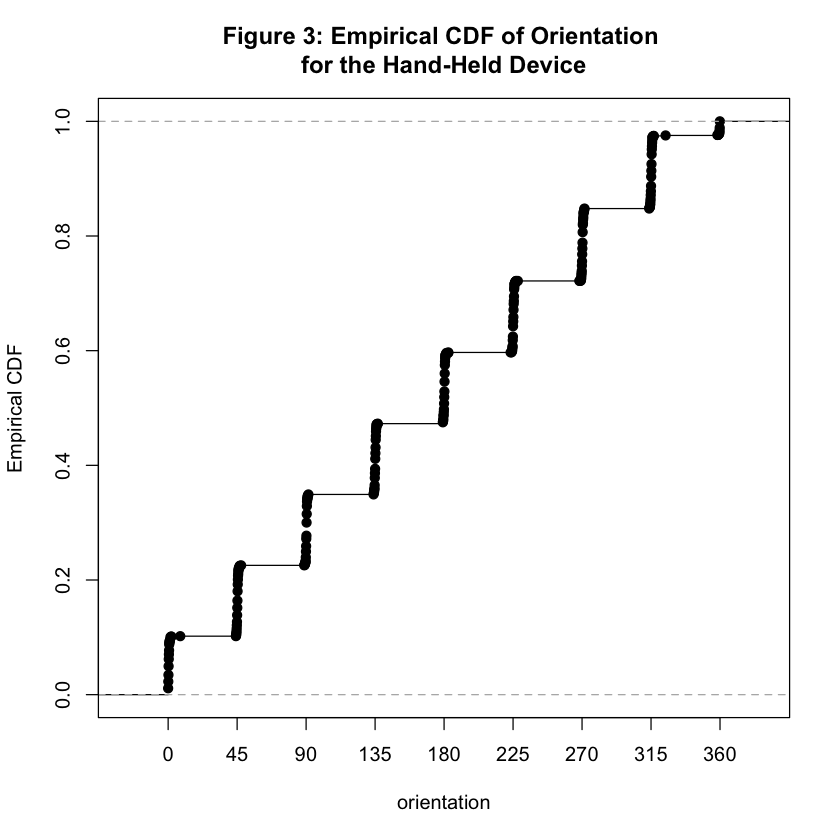

In [18]:
# eliminate posZ since all values = 0, measurements only taken on 1st floor.
# eliminate scanMac since there is only one value
offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

# check for 8 values for orientation angle should be every 45
length(unique(offline$orientation))

# examine distribution of orientation
#png(filename = "Geo_ECDFOrientation.png", width = 800, height = 679, units="px", res=100)
plot(ecdf(offline$orientation), main = "Figure 3: Empirical CDF of Orientation \nfor the Hand-Held Device", ylab = "Empirical CDF", xlab = "orientation", axes=FALSE)
axis(side = 1, at = seq(0, 360, by = 45))
axis(2)
box()
dev.off()

### Defines the roundOrientation Function and Graphs the Orientation to ensure each orientation has its own orientation

null device 
          1

null device 
          1

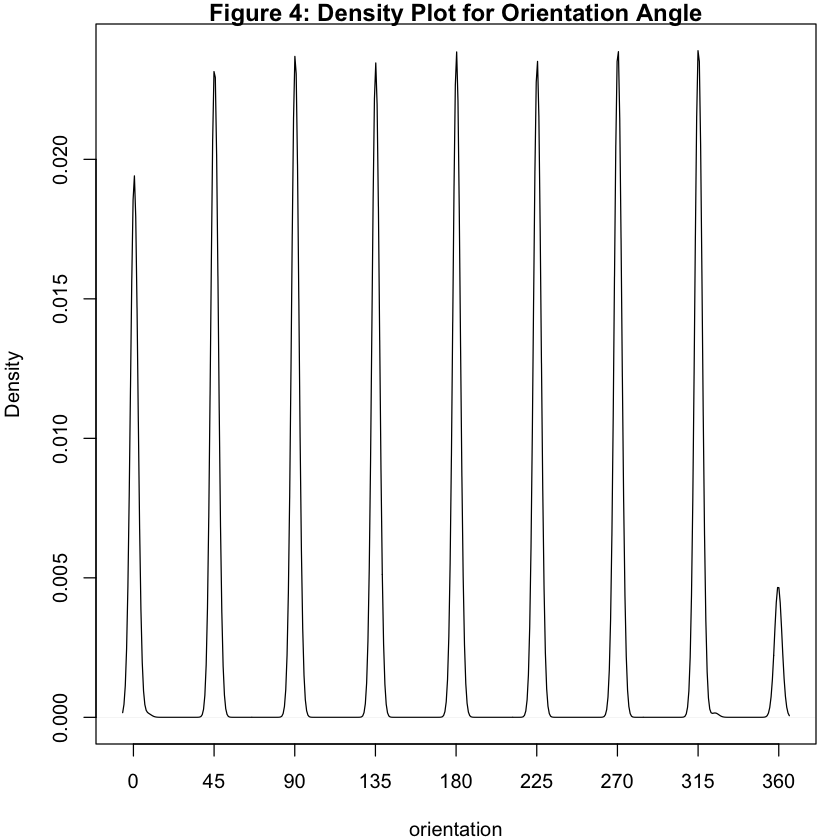

In [22]:
#pdf(file = "Geo_DensityOrientation.pdf", width = 10, height = 5)
oldPar = par(mar = c(4, 4, 1, 1))
plot(density(offline$orientation, bw = 2), 
     xlab = "orientation", main = "Figure 4: Density Plot for Orientation Angle", axes=FALSE)
axis(side = 1, at = seq(0, 360, by = 45))
axis(2)
box()
par(oldPar)

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

offline$angle = roundOrientation(offline$orientation)

#pdf(file = "Geo_BoxplotAngle.pdf", width = 10)
oldPar = par(mar = c(4, 4, 1, 1))

par(oldPar)
dev.off()

### Code for MAC Address A Data Cleaning

In [135]:
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline0 = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline0) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline0 = offline0[ offline0$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline0 = offline0[ , !( names(offline0) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline0 = offline0[ offline0$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline0[ numVars ] = lapply(offline0[ numVars ], as.numeric)

    # convert time to POSIX
    offline0$rawTime = offline0$time
    offline0$time = offline0$time/1000
    class(offline0$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline0$angle = roundOrientation(offline0$orientation)
      
    return(offline0)
  }

In [136]:
offlineRedo = readData()
macChannel0 = with(offlineRedo, table(mac))
apply(macChannel0, 1, function(x) sum(x > 0))

00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
                1                 1                 1                 1 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1

### Code for MAC Address A Predictions 

In [205]:
macs = unique(offlineSummaryRedo$mac)
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummaryRedo = do.call("rbind", byLoc)  

dim(onlineSummaryRedo)

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 593   0   0   0   0
  0.15-9.42    0   0 606   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 573   0   0
  0.47-8.2   590   0   0   0   0   0   0   0
  0.78-10.94 586   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 583   0   0   0

[1] 60 11

In [206]:
names(onlineSummaryRedo)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [207]:
offlineSubset = 
  offlineSummaryRedo[ offlineSummaryRedo$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [208]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [209]:
train130 = selectTrain(130, offlineSummaryRedo, m = 3)

head(train130)

length(train130[[1]])

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

findNN2 = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(list(trainSubset[closest, 1:3 ],dists[order(dists)]))
}

,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-52,-66,-63,-36,-64,-55
0-1,0-1,0,1,-53,-65,-64,-39,-65,-59
0-10,0-10,0,10,-56,-66,-69,-45,-67,-50
0-11,0-11,0,11,-55,-67,-70,-48,-67,-55
0-12,0-12,0,12,-56,-70,-72,-45,-67,-50
0-13,0-13,0,13,-55,-71,-73,-43,-69,-54


[1] 166

In [210]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYkRedo = predXY(newSignals = onlineSummaryRedo[ , 6:11], 
                 newAngles = onlineSummaryRedo[ , 4], 
                 offlineSummaryRedo, numAngles = 3, k = 6)
#estXYkRedo

### MAC Address A Alternative Location Methodology

In [213]:
#Modify findNN to utilize distance output for estimation efforts
predXYaltredo = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  closeDist = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    fnnResult =
    findNN2(newSignal = as.numeric(newSignals[i, ]), trainSS)
  
    closeXY[[i]] = fnnResult[[1]]
    closeDist[[i]] = fnnResult[[2]]
  }
  
  distWeight = list(length = length(closeDist))
  
  for (i in 1:length(closeDist)){
    distW = list(length = k)

    for (j in 1:k){
      distW[j] = (1/closeDist[[i]][j])/sum(1/closeDist[[i]][1:k])
    }
     
    distWeight[[i]] =  distW
  }

  estXYDetails = list(length=length(closeXY))
  
  for(i in 1:length(closeXY)){
    estXYDetails[[i]] = as.matrix(closeXY[[i]][1:k,2:3]) * unlist(distWeight[[i]])
  }
  
  estXY = lapply(estXYDetails,
                 function(x) apply(x, 2,
                                   function(x) sum(x)))
    
  estXY = do.call("rbind", estXY)
  return(estXY)
}
                                   
estXYkRedoalt = predXYaltredo(newSignals = onlineSummaryRedo[ , 6:11], 
                 newAngles = onlineSummaryRedo[ , 4], 
                 offlineSummaryRedo, numAngles = 3, k = 6)

In [214]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXYRedo = onlineSummaryRedo[ , c("posX", "posY")]
sapply(list(estXYkRedo,estXYkRedoalt), calcError, actualXYRedo)

[1] 272 271

### Code for MAC Address B Data Cleaning

In [137]:
readDataNew = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline1 = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline1) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline1 = offline1[ offline1$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline1 = offline1[ , !( names(offline1) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline1 = offline1[ offline1$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline1[ numVars ] = lapply(offline1[ numVars ], as.numeric)

    # convert time to POSIX
    offline1$rawTime = offline1$time
    offline1$time = offline1$time/1000
    class(offline1$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline1$angle = roundOrientation(offline1$orientation)
      
    return(offline1)
  }

In [138]:
offlinenew = readDataNew()
macChannel1 = with(offlinenew, table(mac))
apply(macChannel1, 1, function(x) sum(x > 0))

00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
                1                 1                 1                 1 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1

### Code for MAC Address B Predictions 

In [194]:
macs = unique(offlineSummarynew$mac)
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummarynew = do.call("rbind", byLoc)  

dim(onlineSummarynew)

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 594   0   0   0   0
  0.15-9.42    0   0 608   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 574   0   0
  0.47-8.2   591   0   0   0   0   0   0   0
  0.78-10.94 585   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 581   0   0   0

[1] 60 11

In [195]:
names(onlineSummarynew)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [196]:
offlineSubset = 
  offlineSummarynew[ offlineSummarynew$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [197]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [198]:
train130 = selectTrain(130, offlineSummarynew, m = 3)

head(train130) 

length(train130[[1]])

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

findNN2 = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(list(trainSubset[closest, 1:3 ],dists[order(dists)]))
}

,posXY,posX,posY,00:0f:a3:39:dd:cd,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-72,-66,-63,-36,-64,-55
0-1,0-1,0,1,-70,-65,-64,-39,-65,-59
0-10,0-10,0,10,-70,-66,-69,-45,-67,-50
0-11,0-11,0,11,-71,-67,-70,-48,-67,-55
0-12,0-12,0,12,-69,-70,-72,-45,-67,-50
0-13,0-13,0,13,-73,-71,-73,-43,-69,-54


[1] 166

In [199]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYknew = predXY(newSignals = onlineSummarynew[ , 6:11], 
                 newAngles = onlineSummarynew[ , 4], 
                 offlineSummarynew, numAngles = 3, k = 6)

### MAC Address B Alternative Location Methodology

In [203]:
#Modify findNN to utilize distance output for estimation efforts
predXYalt = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  closeDist = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    fnnResult =
    findNN2(newSignal = as.numeric(newSignals[i, ]), trainSS)
  
    closeXY[[i]] = fnnResult[[1]]
    closeDist[[i]] = fnnResult[[2]]
  }
  
  distWeight = list(length = length(closeDist))
  
  for (i in 1:length(closeDist)){
    distW = list(length = k)

    for (j in 1:k){
      distW[j] = (1/closeDist[[i]][j])/sum(1/closeDist[[i]][1:k])
    }
     
    distWeight[[i]] =  distW
  }

  estXYDetails = list(length=length(closeXY))
  
  for(i in 1:length(closeXY)){
    estXYDetails[[i]] = as.matrix(closeXY[[i]][1:k,2:3]) * unlist(distWeight[[i]])
  }
  
  estXY = lapply(estXYDetails,
                 function(x) apply(x, 2,
                                   function(x) sum(x)))
    
  estXY = do.call("rbind", estXY)
  return(estXY)
}

estXYknewalt = predXYalt(newSignals = onlineSummarynew[ , 6:11], 
                 newAngles = onlineSummarynew[ , 4], 
                 offlineSummarynew, numAngles = 3, k = 6)                                  

In [204]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXYnew = onlineSummarynew[ , c("posX", "posY")]
sapply(list(estXYknew,estXYknewalt), calcError, actualXYnew)

[1] 252 242

### Code for Both MAC Addresses

In [139]:
readDataBoth = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline2 = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline2) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline2 = offline2[ offline2$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline2 = offline2[ , !( names(offline2) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline2 = offline2[ offline2$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline2[ numVars ] = lapply(offline2[ numVars ], as.numeric)

    # convert time to POSIX
    offline2$rawTime = offline2$time
    offline2$time = offline2$time/1000
    class(offline2$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline2$angle = roundOrientation(offline2$orientation)
      
    return(offline2)
  }

In [140]:
offlineBoth = readDataBoth()
macChannel2 = with(offlineBoth, table(mac))
apply(macChannel2, 1, function(x) sum(x > 0))

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

### Code for Both MAC Address Predictions

In [181]:
macs = unique(offlineSummaryBoth$mac)
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummaryBoth = do.call("rbind", byLoc)  

dim(onlineSummaryBoth)

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 704   0   0   0   0
  0.15-9.42    0   0 717   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 684   0   0
  0.47-8.2   701   0   0   0   0   0   0   0
  0.78-10.94 695   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 691   0   0   0

[1] 60 12

In [173]:
names(onlineSummaryBoth)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [174]:
offlineSubset = 
  offlineSummaryBoth[ offlineSummaryBoth$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [175]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [191]:
train130 = selectTrain(130, offlineSummaryBoth, m = 3)

head(train130)

length(train130[[1]])

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:10], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}
                
findNN2 = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:10], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(list(trainSubset[closest, 1:3 ],dists[order(dists)]))
}

,posXY,posX,posY,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-72,-52,-66,-63,-36,-64,-55
0-1,0-1,0,1,-70,-53,-65,-64,-39,-65,-59
0-10,0-10,0,10,-70,-56,-66,-69,-45,-67,-50
0-11,0-11,0,11,-71,-55,-67,-70,-48,-67,-55
0-12,0-12,0,12,-69,-56,-70,-72,-45,-67,-50
0-13,0-13,0,13,-73,-55,-71,-73,-43,-69,-54


[1] 166

In [187]:
predXYboth = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYkBoth = predXYboth(newSignals = onlineSummaryBoth[ , 6:12], 
                 newAngles = onlineSummaryBoth[ , 4], 
                 offlineSummaryBoth, numAngles = 3, k = 6)

### Both MAC Address Althernative Location Methodology

In [192]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  closeDist = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    fnnResult =
    findNN2(newSignal = as.numeric(newSignals[i, ]), trainSS)
  
    closeXY[[i]] = fnnResult[[1]]
    closeDist[[i]] = fnnResult[[2]]
  }
  
  distWeight = list(length = length(closeDist))
  
  for (i in 1:length(closeDist)){
    distW = list(length = k)

    for (j in 1:k){
      distW[j] = (1/closeDist[[i]][j])/sum(1/closeDist[[i]][1:k])
    }
     
    distWeight[[i]] =  distW
  }

  estXYDetails = list(length=length(closeXY))
  
  for(i in 1:length(closeXY)){
    estXYDetails[[i]] = as.matrix(closeXY[[i]][1:k,2:3]) * unlist(distWeight[[i]])
  }
  
  estXY = lapply(estXYDetails,
                 function(x) apply(x, 2,
                                   function(x) sum(x)))
    
  estXY = do.call("rbind", estXY)
  return(estXY)
}
                estXYkBothalt2 = predXY(newSignals = onlineSummaryBoth[ , 6:12], 
                 newAngles = onlineSummaryBoth[ , 4], 
                 offlineSummaryBoth, numAngles = 3, k = 6)

In [193]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXYBoth = onlineSummaryBoth[ , c("posX", "posY")]
sapply(list(estXYkBoth,estXYkBothalt2), calcError, actualXYBoth)




[1] 211 207